In [3]:
#region imports
from IPython import get_ipython

# noinspection PyBroadException
try:
    _magic = get_ipython().run_line_magic
    _magic("load_ext", "autoreload")
    _magic("autoreload", "2")
except:
    pass

# noinspection PyUnresolvedReferences
import datetime as dt
# noinspection PyUnresolvedReferences
import glob
# noinspection PyUnresolvedReferences
import os
# noinspection PyUnresolvedReferences
import pprint
# noinspection PyUnresolvedReferences
import sys
# noinspection PyUnresolvedReferences
import cartopy as crt
# noinspection PyUnresolvedReferences
import matplotlib as mpl
# noinspection PyUnresolvedReferences
import matplotlib.colors
# noinspection PyUnresolvedReferences
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
import numpy as np
# noinspection PyUnresolvedReferences
import pandas as pd
# noinspection PyUnresolvedReferences
import seaborn as sns
# noinspection PyUnresolvedReferences
import xarray as xr
# noinspection PyUnresolvedReferences
#import bnn_tools.bnn_array

import mod.funs as fu

plt.style.use('default')
xr.set_options(
    display_expand_data = False,
    display_expand_data_vars = True,
    display_max_rows = 10,
    display_style = 'html',
    display_width = 80,
    display_expand_attrs = False
);
#endregion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
cols = [
    'Matlab datenum',
    'event Ia',
    'event Ib',
    'event II',
    'event Apple',
    'event Bump',
    'event Rain',
    'event Featureless',
    'non event',
    'undefined',
    'bad data',
    'partly bad data',
    'checksum',
]

In [61]:
p = '../../data/data_orig/DMPS_Event_Classification_1996-2022.txt'

d = (
    pd.read_csv(p,names = cols,comment='%', sep='\s+')
    .assign(day=lambda d:pd.to_datetime(d['Matlab datenum'] - 719529, unit='D').round('10T'))
    .set_index('day')
    ['2018-01-01':]
    .drop('Matlab datenum',axis=1)
    .drop('checksum',axis=1)
    .drop('bad data',axis=1)
    # [['event Ib','event II','bad data','non event', 'undefined']]
)

ds = d.sum()


In [62]:
d1=(
    d.stack()
    .where(lambda d:d>0)
    .dropna()
    .reset_index()
    .drop_duplicates('day')
    .set_index('day')
    .rename({'level_1':'npf_class'},axis=1)
    ['npf_class']
    .to_xarray()
)

d1

<xarray.DataArray 'npf_class' (day: 1788)>
'non event' 'undefined' 'non event' ... 'non event' 'non event' 'non event'
Coordinates:
  * day      (day) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31

In [63]:
d1.to_dataframe()[d1['day'].to_series().duplicated()]

,npf_class
day,


In [64]:
N = '$N_{2.5-5\mathrm{nm}}$'
d5 = (
    xr.open_dataset('../../data/d1/ds_5.nc')
    .rename({'N':N})
    .pipe(lambda d: xr.merge([d,d1]))
    .squeeze()
)

In [103]:
res = (
    d5
    [['q','npf_class']]
    # .assign({'qCut':lambda d:d['qCut'].str.replace('\.0','')})
    .to_dataframe()
    # .where(lambda d:d['qCut']!='nan')
    .dropna(how='all')
    .rename({'npf_class':'Classification'},axis=1)
    .rename({'q':'Percentile ranking'},axis=1)
    # .sort_values('qCut')

)

In [104]:
res

,Percentile ranking,Classification,n_day,n_night,g,qCut
day,,,,,,
2018-01-01,0.566394,non event,47,24,g1,"(0.0, 5.0]"
2018-01-02,70.673379,undefined,47,31,g1,"(70.0, 75.0]"
2018-01-03,16.488357,non event,47,31,g1,"(15.0, 20.0]"
2018-01-04,2.580239,undefined,47,31,g1,"(0.0, 5.0]"
2018-01-05,53.429830,non event,47,31,g1,"(50.0, 55.0]"
...,...,...,...,...,...,...
2022-12-27,NaN,non event,0,0,,nan
2022-12-28,NaN,undefined,0,0,,nan
2022-12-29,NaN,non event,0,0,,nan


In [105]:
ord_ = np.unique(res['qCut'])

0

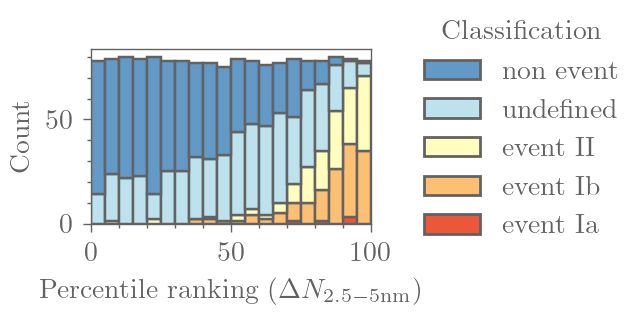

In [118]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot
sns.histplot(
    data = res,
    x = 'Percentile ranking',
    hue = 'Classification',
    multiple='stack',
    bins = np.arange(0,101,5),
    # palette='tab10',
    # palette='Set2',
    palette='RdYlBu_r',
    hue_order = pd.Series(['event Ia','event Ib', 'event II', 'undefined','non event'])[::-1],
    # order = ord_
    alpha = 1
)

ax:plt.Axes = plt.gca()
ax.set_xlim(0,100)
ax.set_box_aspect(1/1.6)
sns.move_legend(ax,'upper left', bbox_to_anchor=(1.1, 1.3))

ax.set_xlabel('Percentile ranking ($\Delta N_{2.5-5\mathrm{nm}}$)')

f:plt.Figure = plt.gcf()

a_ = 2.5
f.set_size_inches(a_+1,a_/1.6)
import uscit
uscit.set_margin(f,x1=.5,x2=1.4,y1=.5)
# uscit.set_fig_rule(f)
#region temp open fig
_p_ = 'f040.pdf';plt.gcf().savefig(_p_,transparent=True);
os.system(f'open {_p_}')
#endregion temp open fig
